# Figure 3 Hierarchical Bayesian Modelling.

## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## Loading dependencies

In [1]:
Sys.setenv(TAR = "/bin/tar") 

# dataviz dependencies
library(ggplot2)
library(visdat)
library(patchwork)
library(ggsci)
library(grid)
library(gridExtra)
library(report)

# BDA2E-utilities dependencies
library(parallel)
library(rjags)
library(runjags)
library(compute.es)

Warning message:
“package ‘visdat’ was built under R version 3.6.3”Warning message:
“package ‘patchwork’ was built under R version 3.6.3”Warning message:
“package ‘ggsci’ was built under R version 3.6.3”Warning message:
“package ‘gridExtra’ was built under R version 3.6.3”Warning message:
“package ‘rjags’ was built under R version 3.6.3”Loading required package: coda
Warning message:
“package ‘coda’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


##  Figure 3a

This figure is not a plot generated from code, but a diagram to explain the modeling.

##  Figure - DBDA2Eprograms plots

code from: [dimorphAS/figures/oldFigureDrafts/figure3b.R](https://github.com/TheJacksonLaboratory/sbas/blob/master/dimorphAS/figures/oldFigureDrafts/figure3b.R)

In [2]:
source("../dimorphAS/DBDA2Eprograms/DBDA2E-utilities.R")


*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



## Retrieving the required data

In [3]:
# Download GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct from Google Cloud 
if (!("GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct" %in% list.files("../data/"))) {
    message("Downloading GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz \nfrom https://console.cloud.google.com/storage/browser/_details/gtex_analysis_v7/rna_seq_data/ ..")
    system("wget -O ../data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz", intern = TRUE)
    message("Done!\n\n")
    message("Unzipping compressed file GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz..")
    system("gunzip ../data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz", intern = TRUE)
    message("Done! \n\nThe file GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct can be found in ../data/")
}

from https://console.cloud.google.com/storage/browser/_details/gtex_analysis_v7/rna_seq_data/ ..
Done!


Unzipping compressed file GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz..
Done! 

The file GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct can be found in ../data/


In [4]:
tissue.list<-c('Heart - Left Ventricle',
               'Breast - Mammary Tissue',
               'Brain - Cortex.Brain - Frontal Cortex (BA9).Brain - Anterior cingulate cortex (BA24)',
               'Adrenal Gland',
               'Adipose - Subcutaneous',
               'Muscle - Skeletal',
               'Thyroid',
               'Cells - Transformed fibroblasts',
               'Artery - Aorta',
               'Skin - Sun Exposed (Lower leg).Skin - Not Sun Exposed (Suprapubic)')

In [5]:
all.genes<-data.table::fread('../data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct',
                              sep='\t',
                              header=TRUE,
                              skip=2,
                              colClasses = c(rep("character", 2), rep("NULL", 11688)))

In [6]:
dim(all.genes)
head(all.genes)

[1] 56202     2

Name,Description
<chr>,<chr>
ENSG00000223972.4,DDX11L1
ENSG00000227232.4,WASH7P
ENSG00000243485.2,MIR1302-11
ENSG00000237613.2,FAM138A
ENSG00000268020.2,OR4G4P
ENSG00000240361.1,OR4G11P


## Filtering out duplicate transcripts ids

In [7]:
all.genes <- all.genes[!duplicated(all.genes$Description),]

In [8]:
dim(all.genes)

[1] 54271     2

## Accessing Position Specific Scoring Matrices (in `dimorphAS/RBP/RBP_PSSMs.zip`)

In [9]:
# Download GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct from Google Cloud 
if (!("RBP_PSSMs" %in% list.files("../data/"))) {
    message("Unzipping ../dimorphAS/RBP/RBP_PSSMs.zip INTO ../data ..\n")
    system("cd ../data/ && unzip ../dimorphAS/RBP/RBP_PSSMs.zip", intern = TRUE)
    message("Done! \n\nThe files can be found in ../data/RBP_PSSMs/")
}

In [10]:
rbp.names <- unique(gsub('_.*','',list.files('../data/RBP_PSSMs/')))

In [11]:
length(rbp.names)

[1] 136

In [12]:
summary.tab<-matrix(ncol=7,
                    nrow=0)

In [13]:
colnames(summary.tab)<-c('Event',
                         'Gene', 
                         'Sig. RBPs',
                         'Sig. Gene Expression',
                         'Sig. Sex',
                         'Tissue',
                         'Dimorphic')

In [14]:
top.rbps<-rbp.names

In [15]:
length(top.rbps)

[1] 136

## Initialising dataframe with columns `coef,rbp,tissue`

In [16]:
df <-data.frame(coef=NULL,rbp=NULL,tissue=NULL)

In [17]:
# Refactoring needed to not rely on hard coded by position id of tissue
tissue <- tissue.list[[1]]

In [18]:
head(tissue)

[1] "Heart - Left Ventricle"

## `{Missing files!}`  Dimorph/McmcMostVaryingMoreSigs_'

## Using cached `.Rdata` until the files Dimorph/McmcMostVaryingMoreSigs_* are located

In [19]:
#Before running the following, use the Session menu to set working directory to source file location
#setwd(dir = "../dimorphAS/DBDA2Eprograms/")
load('../dimorphAS/figures/oldFigureDrafts/figure3b.RData')

### This invokes X11 which is not available for all systems, and won't work in a NextFlow pipeline

```
diagMCMC(mcmcCoda , parName=c("beta2[101,87]"))
```

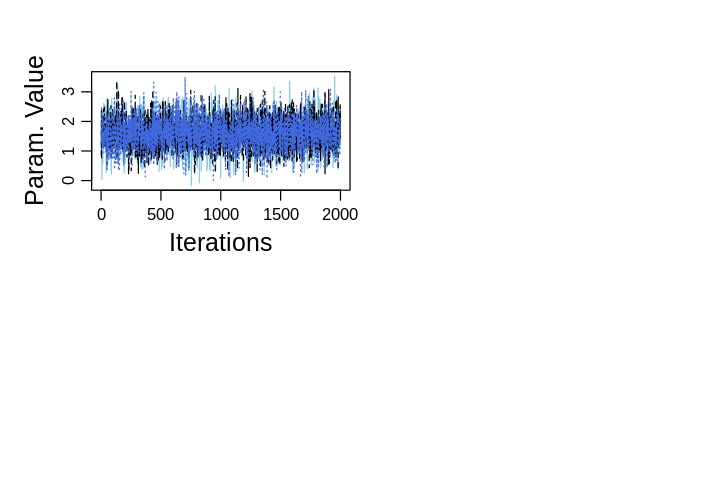

In [53]:
options(repr.plot.width=6, repr.plot.height=4)

codaObject <- mcmcCoda 
parName    <- c("beta2[101,87]") #varnames(codaObject)[1]
saveName   <- NULL
saveType   <- "jpg"


DBDAplColors = c("skyblue",
               "black",
               "royalblue",
               "steelblue")

#openGraph(height=5,width=7)
    
par(mar=0.5+c(3,4,1,0) , 
  oma=0.1+c(0,0,2,0) , 
  mgp=c(2.25,0.7,0) , 
  cex.lab=1.5 )
    
layout(matrix(1:4,nrow=2))
  # traceplot and gelman.plot are from CODA package:
require(coda)
coda::traceplot( codaObject[,c(parName)], 
              main="" , 
              ylab="Param. Value" ,
              col=DBDAplColors )

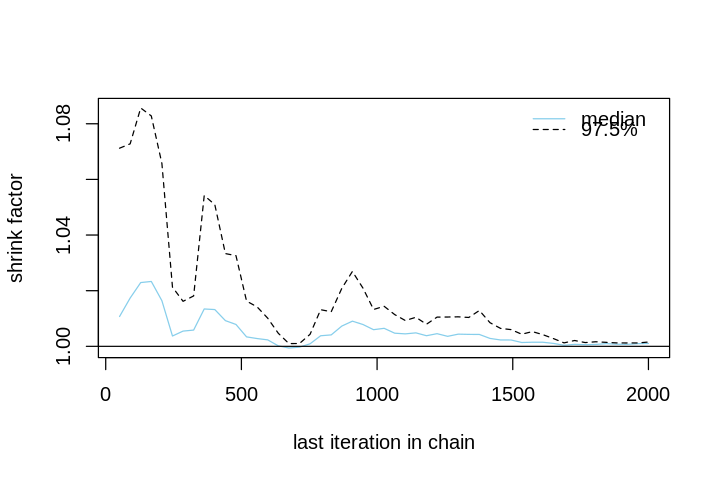

In [52]:
options(repr.plot.width=6, repr.plot.height=4)
tryVal = try(
coda::gelman.plot(codaObject[,c(parName)] , 
                  main="",
                  auto.layout=FALSE,
                  col=DBDAplColors )
)  

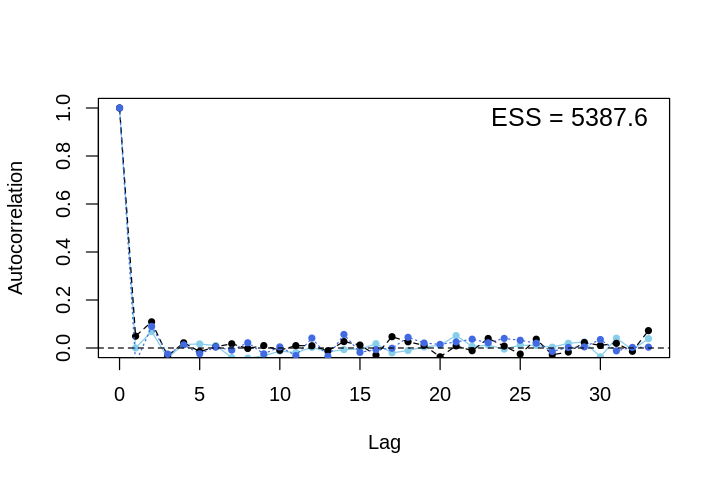

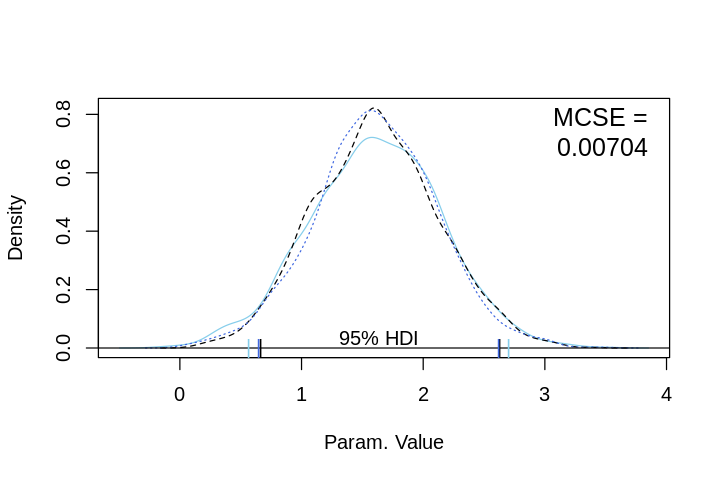

In [51]:
options(repr.plot.width=6, repr.plot.height=4)

# if it runs, gelman.plot returns a list with finite shrink values:
  if ( class(tryVal)=="try-error" ) {
    plot.new() 
    print(paste0("Warning: coda::gelman.plot fails for ",parName))
  } else { 
    if ( class(tryVal)=="list" & !is.finite(tryVal$shrink[1]) ) {
      plot.new() 
      print(paste0("Warning: coda::gelman.plot fails for ",parName))
    }
  }
  DbdaAcfPlot(codaObject,parName,plColors=DBDAplColors)
  DbdaDensPlot(codaObject,parName,plColors=DBDAplColors)
  mtext( text=parName , outer=TRUE , adj=c(0.5,0.5) , cex=2.0 )
  if ( !is.null(saveName) ) {
    saveGraph( file=paste0(saveName,"Diag",parName), type=saveType)
  }



## Figure 3b 

code from: [dimorphAS/figures/figure3/figure3e.R](https://github.com/TheJacksonLaboratory/sbas/blob/master/dimorphAS/figures/figure3e/figure3e.R)

### NOTE:

Because the files  `'/Users/karleg/Dimorph/', tissue,'_Expression_comparison_other.txt')` are missing we will reproduce using the stored Rdata

### Loading relevant .Rdata for figure 3b

In [48]:
load("../dimorphAS/figures/figure3/figure3e.Rdata")

MATR3      RBM6      MSI1    ZNF638     ESRP2   KHDRBS3      YBX1       FUS 
      124        96        88        88        84        84        84        82 
   HNRNPC  HNRNPCL1   KHDRBS1      FXR2      TIA1     PCBP1     PTBP1     RBM42 
       78        78        76        74        74        72        70        70 
    SRSF9    PABPN1     RBM45    SAMD4A      RALY     RBM28     SRP54      YBX2 
       70        68        66        66        64        64        64        64 
    RBM38    SRSF10     G3BP2     RBM24     RBM41       SF1     SRSF7    HNRNPK 
       62        62        60        60        60        60        60        58 
    CPEB4    PABPC1    ZC3H14      RBM4     SNRPA      PUM2       QKI    TARDBP 
       54        54        52        50        50        48        48        48 
     A1CF    DAZAP1      FXR1 HNRNPA1L2 HNRNPA2B1     PPRC1    PABPC5    HNRNPF 
       46        46        46        46        46        46        44        42 
   HNRNPL    PABPC3      RBM3      RSF1   HNRNPH1     MBNL1     PCBP3     RBMS3 
       42        42        42        42        40        40        40        40 
   RBFOX1      RBM5     SRSF1     ZCRB1     CPEB2   KHDRBS2     SRSF2     ENOX1 
       38        38        38        38        36        36        36        34 
  SNRNP70     SART3     U2AF2   HNRNPA1    HNRNPM      SFPQ   IGF2BP2      TUT1 
       34        32        32        30        28        28        26        26 
   LIN28A     RBM46      FMR1    ANKHD1     CNOT4       CPO     RBMS1   HNRNPH2 
       24        24        22        20        20        20        20        18 
    PCBP2    ZC3H10   IGF2BP3    PABPC4    HNRNPU     RBM8A      RBP1 
       18        18        16        16        12        12        10

[1] "ESRP2"   "FUS"     "HNRNPC"  "KHDRBS3" "MATR3"   "MSI1"    "PTBP1"  
 [8] "RBM6"    "SRSF9"   "TIA1"    "YBX1"

ZNF638      U2AF2      MATR3      G3BP2     PABPN1    HNRNPH2      PCBP1 
231.755299 103.318147 101.669403  97.490804  82.390970  80.885843  73.804518 
     RBM46    KHDRBS1   HNRNPCL1      CNOT4       FXR2      RBM38     HNRNPK 
 73.248530  73.012378  67.281303  66.499616  66.096933  65.947227  65.677914 
    RBFOX1     HNRNPU       PUM2  HNRNPA1L2      SART3     ANKHD1       SFPQ 
 55.187211  54.810143  53.974435  53.892585  53.032179  52.711193  51.332509 
    SRSF10      PCBP2      MBNL1      RBMS1       RBM5    KHDRBS3      RBM28 
 50.772649  50.760958  50.231449  50.195396  48.409528  47.706766  45.857959 
    TARDBP    HNRNPH1        SF1       RSF1      PPRC1      RBM8A        FUS 
 45.246139  44.974131  44.624317  44.615520  43.899839  43.770269  43.082798 
 HNRNPA2B1     DAZAP1       FXR1       FMR1     HNRNPM       RALY      SRSF7 
 42.041978  41.609897  40.686239  40.510028  40.025274  39.567994  39.556289 
     PTBP1      SRP54       YBX1     HNRNPF      SRSF2       TIA1      ESRP2 
 39.528589  39.514450  39.206720  37.887832  37.297149  37.252155  36.634561 
   SNRNP70      SRSF9      SRSF1     SAMD4A      RBM42     ZC3H14       MSI1 
 36.395626  36.266005  35.241413  34.842829  34.755535  34.566477  34.524603 
     RBM41       RBM6      ZCRB1     PABPC1     HNRNPL       RBM4       YBX2 
 33.944720  33.659808  33.105912  32.838818  30.499826  30.068266  29.586932 
      TUT1    KHDRBS2      SNRPA      RBM24        QKI       A1CF     PABPC5 
 29.441722  29.009331  28.977902  28.242014  28.229992  27.798353  27.014612 
      RBP1    HNRNPA1    IGF2BP2      CPEB2      RBMS3      ENOX1      CPEB4 
 25.276456  24.367689  23.810469  23.515433  23.102089  22.750701  21.470619 
     RBM45     ZC3H10     PABPC4        CPO     HNRNPC     PABPC3       RBM3 
 21.101487  20.366223  20.057415  19.245043  18.724108  18.680154  18.237319 
   IGF2BP3      PCBP3     LIN28A 
 15.960443  15.322752   8.732186

Warning message:
“Removed 30 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2 rows containing non-finite values (stat_ydensity).”

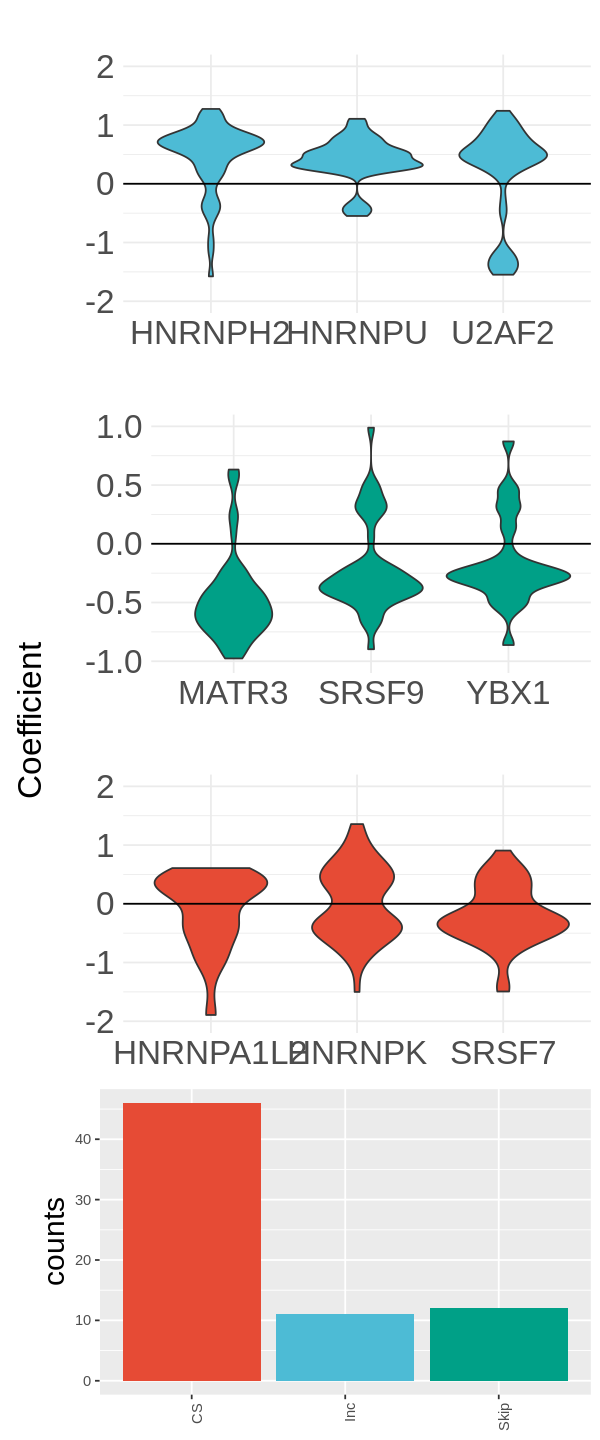

Warning message:
“Removed 4 rows containing non-finite values (stat_ydensity).”

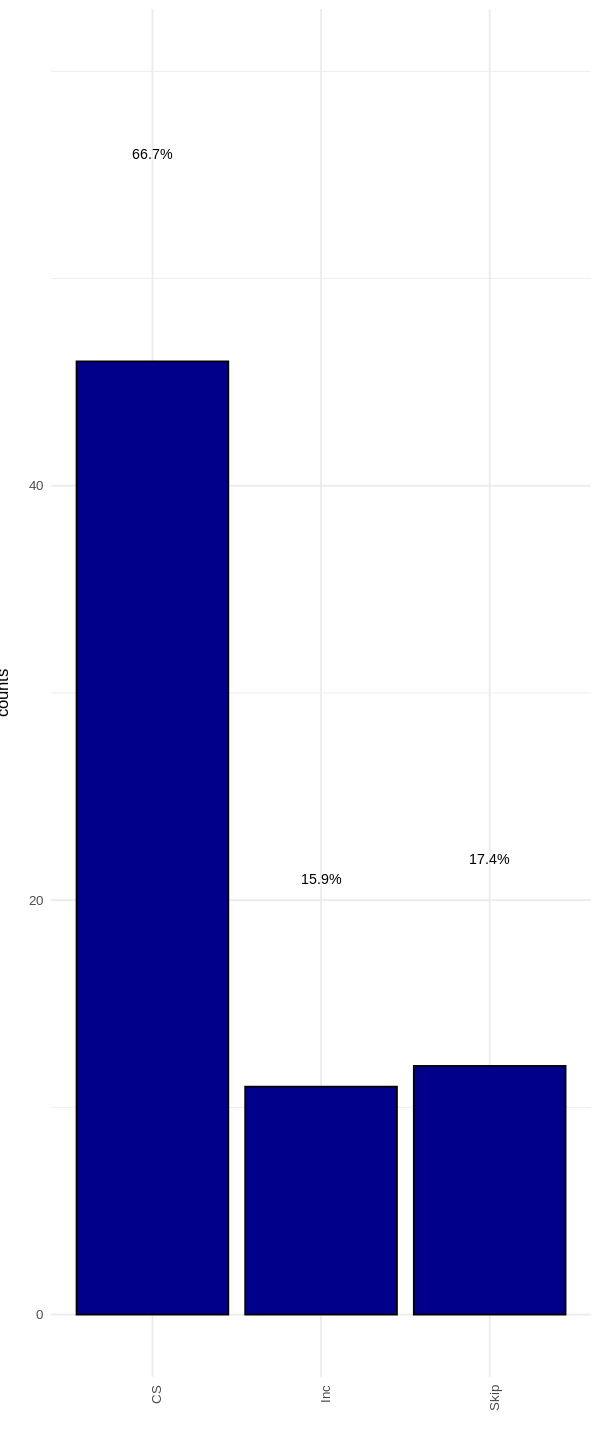

In [70]:
options(repr.plot.width=5, repr.plot.height=12)

pn1<-ggplot(df1,aes(factor(RBP),Coef)) + 
        geom_violin(aes(fill='red')) + 
        scale_fill_manual(values = '#4DBBD5FF')+
        theme_minimal() + 
        theme(text = element_text(size=20),
              axis.text = element_text(size=20, hjust=0.5),
              axis.title.x=element_blank(),
              axis.title.y = element_text(size=24),
              plot.title = element_text(hjust = 0.5),
              legend.position = "none") + ylab("") + 
        labs(title="")+
        ylim(-2,2)+ 
        geom_hline(yintercept=0)

#pn <- pn +  geom_dotplot(binaxis='y', stackdir='center', dotsize=0.5)


sort(sum.neg,decreasing = T)

neg.rbps

sort(unlist(lapply(lapply(split(df$Coef,df$RBP),abs),sum)),decreasing = T)

df2<-df[df$RBP %in% c("YBX1", "SRSF9","MATR3"),]

pn2<-ggplot(df2,aes(factor(RBP),Coef)) +geom_violin(aes(fill='blue'))+ scale_fill_manual(values = '#00A087FF')
pn2 <- pn2 + theme_minimal() +  theme(text = element_text(size=20),
                                      axis.text = element_text(size=20, hjust=0.5),
                                      axis.title.x=element_blank(),
                                      axis.title.y = element_text(size=24),
                                      plot.title = element_text(hjust = 0.5),
                                      legend.position = "none") + ylab("") + labs(title="")+ylim(-1,1)+ geom_hline(yintercept=0)
#pn <- pn +  geom_dotplot(binaxis='y', stackdir='center', dotsize=0.5)


df3<-df[df$RBP %in% c("HNRNPK", "HNRNPA1L2","SRSF7"),]

pn3<-ggplot(df3,aes(factor(RBP),Coef)) +geom_violin(aes(fill='green')) + scale_fill_manual(values = '#E64B35FF') 
pn3 <- pn3 + theme_minimal() +  theme(text = element_text(size=20),
                                      axis.text = element_text(size=20, hjust=0.5),
                                      axis.title.x=element_blank(),
                                      axis.title.y = element_text(size=24),
                                      plot.title = element_text(hjust = 0.5),
                                      legend.position = "none") + ylab("") + labs(title="")+ylim(-2,2)+ geom_hline(yintercept=0)
#pn <- pn +  geom_dotplot(binaxis='y', stackdir='center', dotsize=0.5)


pn4<-ggplot(df.counts, aes(type, counts)) +  geom_bar(aes(fill = type), position = "dodge", stat="identity") + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+ scale_fill_npg() + guides(fill=FALSE)+theme(axis.title.x=element_blank(),axis.title=element_text(size=18))



grid.arrange(pn1,pn2,pn3,pn4, nrow = 4,
             left = textGrob('Coefficient',gp = gpar(fontsize = 20), rot = 90,vjust=1))

df1$facet = 1
df2$facet = 2
df3$facet = 3
df_c <- rbind(df1, df2, df3)
p <- ggplot(df_c,aes(x = factor(RBP), y = Coef, fill = factor(RBP))) + 
  geom_violin() + facet_wrap(~facet, nrow = 3, scales = "free") + 
  xlab("") + ylab("") + ylim(-2,2)+ geom_hline(yintercept=0) + scale_fill_npg() +
  theme_minimal() +  theme(text = element_text(size=20),
                                      axis.text = element_text(size=8, hjust=0.5),
                                      axis.title.x=element_blank(),
                                      axis.title.y = element_text(size=8),
                                      plot.title = element_text(hjust = 0.5),
                                      legend.position = "none", 
                           strip.text = element_blank())
  
pn4_new <- ggplot(df.counts, aes(type, counts)) +  
  geom_bar(fill = "#00008B",color="black", position = "dodge", stat="identity") + 
  geom_text(aes(x = type, y = counts + 10, label = paste(100 * round(counts/sum(counts), 3), "%", sep = "")), size = 3) +
  guides(fill=FALSE) +
  xlab("") + scale_y_continuous(breaks = c(0, 20, 40), limits = c(0, 60))+
  theme_minimal() +
  theme(
        axis.text = element_text(size = 8), 
        axis.text.x = element_text(angle = 90, hjust = 1), 
        axis.title = element_text(size = 10),
        axis.title.y = element_text(vjust = 5)
        )
pn4_new  
p_grid <- arrangeGrob(p,pn4_new, nrow = 2, heights = c(3, 1), 
             left = textGrob('Coefficient',gp = gpar(fontsize = 10), rot = 90,vjust=1, hjust = -0.2))

##  Figure 3c
**EDIT**: 
This code comes from `dimorphAS/notebook/figure4a` but corresponds to the figure **`Figure 3c`** of the publication.

This script creates figure 4a. Please run the following command first:

`perl` [`parseMT.pl`](https://github.com/TheJacksonLaboratory/sbas/blob/master/dimorphAS/notebook/parseMT.pl)

This creates the files needed for figure `4a` and `4b`, namely `lv.txt` and `mt.txt`.
The input file for  [`parseMT.pl`](https://github.com/TheJacksonLaboratory/sbas/blob/master/dimorphAS/notebook/parseMT.pl) is a `.tsv` file name `summary_hbm.txt`. Here is a preview of this file:


In [23]:
summary_hbm   <- utils::read.table(file      = "../dimorphAS//notebook/summary_hbm.txt", 
                                   header    = TRUE, 
                                   sep       = "\t")

In [24]:
dim(summary_hbm)
head(summary_hbm, 2)

[1] 1112    7

,Event,Gene,Sig..RBPs,Sig..Gene.Expression,Sig..Sex,Tissue,Dimorphic
,<int>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,21228,TANK,"CNOT4(-0.21),CPEB2(-0.11),DAZAP1(-0.14),ENOX1(-0.06),HNRNPA1(0.07),HNRNPA2B1(0.22),HNRNPCL1(-0.16),HNRNPF(0.22),HNRNPH1(0.14),HNRNPH2(0.24),KHDRBS1(0.23),KHDRBS3(-0.06),PABPC1(0.12),PABPC5(0.08),PPRC1(0.14),RBFOX1(0.19),RBM4(-0.16),RBM45(0.03),RBM46(-0.13),RBMS3(-0.07),RBP1(-0.05),SAMD4A(0.13),SRSF1(-0.23),SRSF7(-0.12),TARDBP(-0.17),U2AF2(0.25),ZC3H14(0.27)",0.29,0.16,Heart - Left Ventricle,No
2,28196,UBE2E1,"FXR1(-0.16),FXR2(-0.19),HNRNPA2B1(0.19),IGF2BP3(-0.04),KHDRBS1(-0.19),LIN28A(0.02),MSI1(0.05),PABPC3(-0.07),PABPC4(0.11),PABPN1(-0.16),PCBP2(-0.15),RBFOX1(-0.13),RBM4(-0.1),RBM45(-0.03),RBM5(0.11),RBM8A(-0.14),RBMS1(-0.19),RBMS3(0.07),SAMD4A(0.12),SRSF2(0.13),SRSF9(-0.23),U2AF2(0.14),ZC3H14(0.2),ZCRB1(0.13),ZNF638(-0.24)",0.68,0.00,Heart - Left Ventricle,No


In [25]:
if ( ("lv.txt" %in% list.files("../data/")) && ("mt.txt" %in% list.files("../data/"))) {
        message("The files lv.txt or mt.txt are available in the folder ../data/! \n")
        message("The 'perl parseMT.pl' command will not be re-run \n")
}


if ( (!("lv.txt" %in% list.files("../data/"))) | (!("mt.txt" %in% list.files("../data/")))) {
        message("The files lv.txt or mt.txt not found in the folder ../data/ \n")
        message("Generating lv.txt and mt.txt with 'perl parseMT.pl' using 'summary_hbm.txt' as input .. \n")
        system(paste0("cd ../dimorphAS/notebook/ && ",
                      "perl parseMT.pl > parseMT_output.txt && ", 
                      "mv lv.txt ../../data/ && ",
                      "mv mt.txt ../../data/ && ",
                      "cp summary_hbm.txt  ../../data/"), 
               intern  = TRUE)
        message("Done!\n")
}



The files lv.txt or mt.txt are available in the folder ../data/! 

The 'perl parseMT.pl' command will not be re-run 



# Left ventricle data from `lv.txt`

In [26]:
dat           <- utils::read.table("../data/lv.txt", header=FALSE, sep = "\t", col.names = c("RBP", "Expression"))

In [27]:
dim(dat)
summary(dat)

[1] 96  2

      RBP          Expression     
 Min.   : 0.74   Min.   :-1.9400  
 1st Qu.: 1.85   1st Qu.:-0.9425  
 Median : 2.68   Median : 0.0000  
 Mean   : 3.46   Mean   :-0.4017  
 3rd Qu.: 4.46   3rd Qu.: 0.0000  
 Max.   :11.44   Max.   : 0.5200  

## Remove rows where expression values are equal to 0

In [28]:
d2<-dat[dat$Expression!=0,]
d2<-d2[order(d2$Expression),]

In [29]:
dim(d2)
summary(d2)

[1] 37  2

      RBP          Expression    
 Min.   :0.970   Min.   :-1.940  
 1st Qu.:1.860   1st Qu.:-1.370  
 Median :2.970   Median :-1.110  
 Mean   :3.506   Mean   :-1.042  
 3rd Qu.:4.530   3rd Qu.:-0.830  
 Max.   :9.570   Max.   : 0.520  


0.94% of rows in the dataframe were filtered out because they contained 0 values



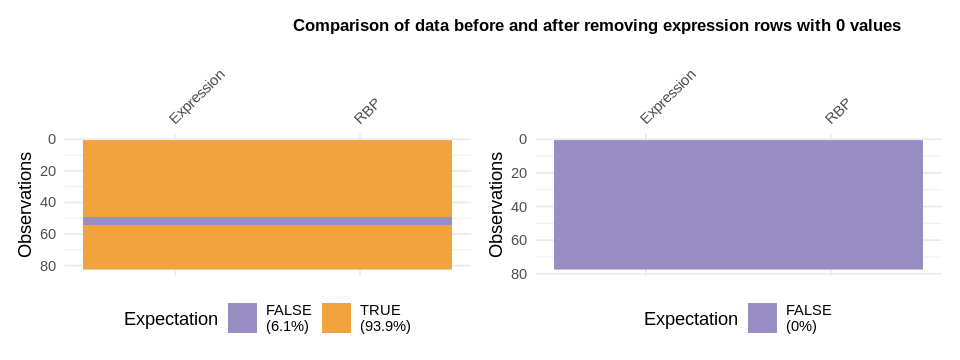

In [46]:
options(repr.plot.width=8, repr.plot.height=3)

dat        <- dat[order(dat$Expression),]
with_zeros <- visdat::vis_expect(dat, ~dat$Expression != 0,  show_perc = TRUE)
no_zeros   <- visdat::vis_expect(d2, ~d2$Expression != 0, show_perc = TRUE)
both       <- with_zeros + no_zeros

message(paste0("\n", round((nrow(d2)/nrow(dat)), 2),"% ","of rows in the dataframe were filtered out because they contained 0 values\n"))

both + labs(title = "Comparison of data before and after removing expression rows with 0 values") + theme(plot.title    = element_text(size = 10, face = "bold" , hjust = 1.2))

We are checking above if our expectation of having none 0 Expression values is true. We can also verify this by the initial and final row count of the dataframe that contains the `RBP` and `Expression` values.

## Fit a linear model (`expression ~ rbm`)

In [31]:
lm_fit   <- lm(d2$Expression ~ d2$RBP, data=d2)
LM       <-summary(lm_fit)
rsquared <-round(LM$r.squared,digits=2)

In [32]:
lm <- report(lm_fit)
lm$tables$table_long

Parameter,Coefficient,SE,CI_low,CI_high,t,df_error,p,Std_Coefficient,Fit
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
(Intercept),-1.5241806,0.13064990,-1.7894140,-1.2589471,-11.666144,35,1.296862e-13,-1.5241806,NA
d2$RBP,0.1374966,0.03146206,0.0736252,0.2013679,4.370235,35,1.056443e-04,0.1374966,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AIC,NA,NA,NA,NA,NA,NA,NA,NA,45.7960906
BIC,NA,NA,NA,NA,NA,NA,NA,NA,50.6288443
R2,NA,NA,NA,NA,NA,NA,NA,NA,0.3530374
R2 (adj.),NA,NA,NA,NA,NA,NA,NA,NA,0.3345527
RMSE,NA,NA,NA,NA,NA,NA,NA,NA,0.4143047


## Save predictions of the model 
Save predictions of the model in a new data frame named `predicted_df` along with the variable we want to plot against.

In [33]:
predicted_df <- data.frame(expr_pred = predict(lm_fit, d2), RBP=d2$RBP)

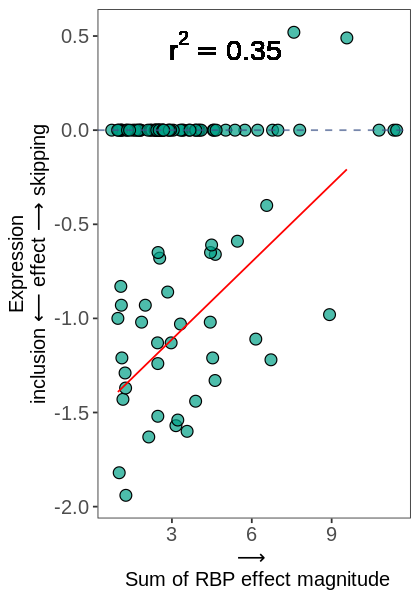

In [34]:
options(repr.plot.width=3.5, repr.plot.height=5)
mypal <- ggsci::pal_npg("nrc", alpha = 0.7)(9)


p<-ggplot(dat, aes(x=RBP, y=Expression)) + geom_point(shape=21,fill = mypal[3],size=3) +  theme_bw()
#+ scale_fill_npg() 
p <- p + theme(axis.text = element_text(size=12, 
                                        hjust=0.5),
               axis.title.x=element_text(size=12),
               axis.title.y = element_text(size=12),
               axis.text.y = element_text(size=12),
               panel.grid.major = element_blank(), 
               panel.grid.minor = element_blank()) 
p <- p +  geom_hline(yintercept=0, linetype="dashed", color = mypal[4])
p <- p +xlab('\U27F6 \n Sum of RBP effect magnitude')+ylab('Expression\ninclusion \U27F5 effect \U27F6 skipping')
p <- p+ geom_line(color='red',data = predicted_df, aes(y=expr_pred, x=RBP))
mylabel<-paste(italic(r)^2~"="~rsquared) 
p1 <- p+ geom_text(x = 5, 
                   y = 0.45, 
                   label = as.character(paste( "r^2==",rsquared)), 
                   size=6, 
                   parse = TRUE)
p1

### (3c) Predicted effects of gene expression vs. RBP levels on exon inclusion in 100 sex-biased SE events in the left ventricle. 

The Y axis shows the mean of the posterior of the coefficient that determines the effects of gene expression on exon inclusion. 
Negative values favour skipping and positive values favour inclusion. 
The X axis shows the sum of the absolute values of the posterior of the coefficients of the 87 RBPs. 
The higher the value, the more the predicted effect on exon skipping. 
In the left frame it can be seen that for 61 out of 100 sex-biased events in left ventricle, 
no effect of gene expression was predicted (flat line at y=0.0). 

For the remaining genes there was a correlation with **`R2=0.35 (p=7.98x10-5).`**

##  Figure 3d


This should be run after the `figure4a.R` script corrsponding to the figure 3b in the manuscript (see above code chunks) 

In [35]:
dat <- read.table("../data/mt.txt", header=FALSE, sep = "\t", col.names = c("RBP", "Expression"))

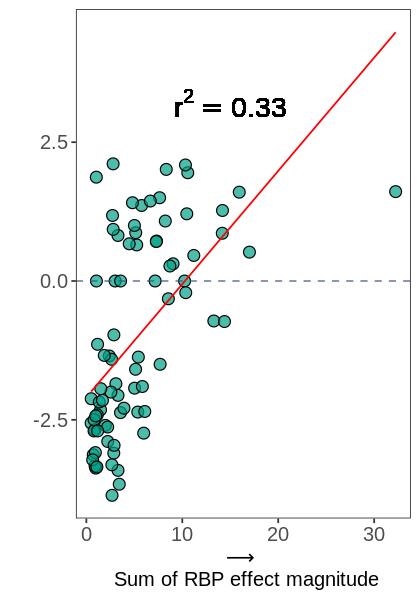

In [36]:
options(repr.plot.width=3.5, repr.plot.height=5)
mypal = pal_npg("nrc", alpha = 0.7)(9)
d2<-dat[dat$Expression!=0,]
lm_fit <- lm(d2$Expression ~ d2$RBP, data=d2)
LM<-summary(lm_fit)
rsquared<-round(LM$r.squared,digits=2)  

# save predictions of the model in the new data frame 
# together with variable you want to plot against
predicted_df <- data.frame(expr_pred = predict(lm_fit, d2), RBP=d2$RBP)


p<-ggplot(dat, aes(x=RBP, y=Expression)) + geom_point(shape=21,fill = mypal[3],size=3) +  theme_bw()
 #+ scale_fill_npg() 
p <- p + theme(axis.text = element_text(size=12, 
                                        hjust=0.5),
               axis.title.x=element_text(size=12),
               axis.title.y = element_text(size=12),
               axis.text.y = element_text(size=12),
               panel.grid.major = element_blank(), 
               panel.grid.minor = element_blank()) 
p <- p +  geom_hline(yintercept=0, linetype="dashed", color = mypal[4])
p <- p +xlab('\U27F6 \n Sum of RBP effect magnitude')+ ylab('')
p <- p+ geom_line(color='red',data = predicted_df, aes(y=expr_pred, x=RBP))
mylabel<-paste(italic(r)^2~"="~rsquared) 
p2 <- p+ geom_text(x = 15, 
                   y = 3.2, 
                   label = as.character(paste( "r^2==",rsquared)), 
                   size=6, 
                   parse = TRUE)
p2

#### (3d) A similar correlation was found in mammary tissue, with R2=0.33 (p=3.6x10-12).


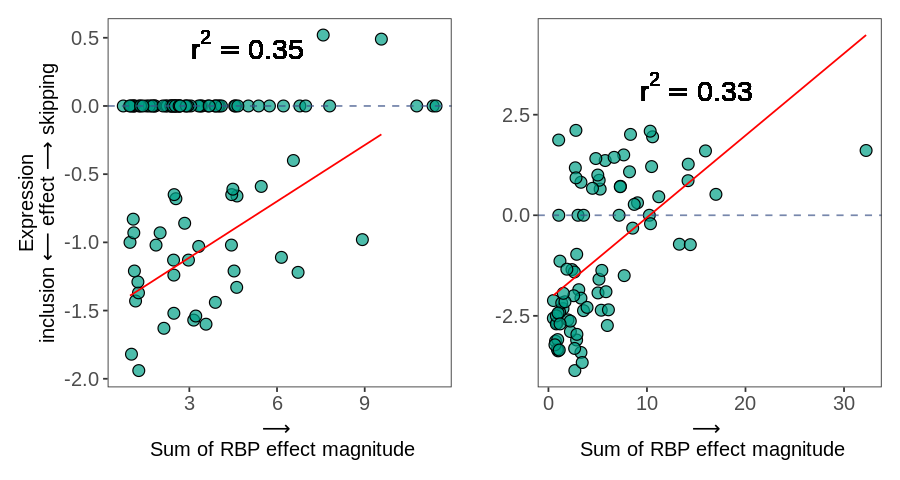

In [37]:
options(repr.plot.width=7.5, repr.plot.height=4)

p1 + p2

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [38]:
figure_id       <- "figures_3"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data/ && find . -type f -exec sha256sum {} \\; > ../metadata/",  figure_id, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", figure_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!



sha256sum,file
<chr>,<chr>
e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855,./README.md
7620b9a77e88b7879af22eb27136e94c993e92a287058bfa3e22244d3963975e,./mt.txt
ec38fac35613da014f73140da90c95294ba52c6e7923e380a5236762f1ca3793,./GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct
947b61563e51232c3276cd4b44d3414d68ea9a419dc74d09375d2bfbb321f08b,./summary_hbm.txt
791589cf6a262a89808f0653db4d01715c5bd92381e53521ccdca3fcc075953c,./RBP_PSSMs/RBM4_gcgcgss_human_PSSM.txt
e2da6d12f918bab56f05c905deee4cec77e224bc1784b22199cd83c750c0d52a,./RBP_PSSMs/TARDBP_gaaugd_human_PSSM.txt
eb8e7624f93a768fe24412f4c070eb86857b1ed9b8defdbf5be29b2da77e98a3,./RBP_PSSMs/ARET_ukukugu_drosophila_PSSM.txt
c807b997c6fabafec009015be164645e3ba8edf453845b60a276eeff6b79e577,./RBP_PSSMs/HNRNPL_amayama_human_PSSM.txt
97e86fc27a363ebd20e7857c0cae7281b3ef3e5721314f020cc40402059ef25c,./RBP_PSSMs/HNRNPA2B1_gguaguag_human_PSSM.txt


### 2. Libraries metadata

In [39]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-03-09                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
coda,coda,0.19.3,0.19-3,/opt/conda/lib/R/library/coda,/opt/conda/lib/R/library/coda,TRUE,FALSE,2019-07-05,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
compute.es,compute.es,0.2.4,0.2-4,/opt/conda/lib/R/library/compute.es,/opt/conda/lib/R/library/compute.es,TRUE,FALSE,2014-09-16,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
ggsci,ggsci,2.9,2.9,/opt/conda/lib/R/library/ggsci,/opt/conda/lib/R/library/ggsci,TRUE,FALSE,2018-05-14,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
patchwork,patchwork,1.0.0,1.0.0,/opt/conda/lib/R/library/patchwork,/opt/conda/lib/R/library/patchwork,TRUE,FALSE,2019-12-01,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
report,report,0.1.0,0.1.0,/opt/conda/lib/R/library/report,/opt/conda/lib/R/library/report,TRUE,FALSE,2020-03-04,Github (easystats/report@dcdd283),NA,/opt/conda/lib/R/library
rjags,rjags,4.10,4-10,/opt/conda/lib/R/library/rjags,/opt/conda/lib/R/library/rjags,TRUE,FALSE,2019-11-06,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
runjags,runjags,2.0.4.6,2.0.4-6,/opt/conda/lib/R/library/runjags,/opt/conda/lib/R/library/runjags,TRUE,FALSE,2019-12-17,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
visdat,visdat,0.5.3,0.5.3,/opt/conda/lib/R/library/visdat,/opt/conda/lib/R/library/visdat,TRUE,FALSE,2019-02-15,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
